## Overview of core astropy.modeling features

- simple models
- fitters
- combined models
- creating new models


In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

[astropy.modeling](http://astropy.readthedocs.io/en/latest/modeling/index.html) is a framework for representing models and evaluating and fitting them.
It is designed to be flexible and easily extensible. 
Models do not reference fitting algorithms explicitly and new fitting algorithms may be 
added without changing the existing models.

### Simple models

A number of predefined models already exist in modeling. They all live under a common namespace - *models*.

In [3]:
from astropy.modeling import models


Most models are defined with their parameters and maintain an ordered list of parameter names.
The names of the parameters can be found directly from the model.

In [14]:
models.Gaussian1D.param_names

('amplitude', 'mean', 'stddev')

They are initialized by providing values for the parameters.

In [5]:
gauss = models.Gaussian1D(amplitude=5.3, mean=3.1, stddev=1.1)

The order of the *Model.param_names* list is important because models can be initialized by simply providing the values as positional arguments

In [17]:
gauss = models.Gaussian1D(5.3, 3.1, 1.1)
print(gauss)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          5.3  3.1    1.1


Model parameters are objects with attributes:

In [6]:
gauss.mean

Parameter('mean', value=3.1)

In [18]:
print(gauss.mean.name)

mean


In [19]:
print(gauss.mean.value)


3.1


Most models have default values for their parameters and can be initialized without providing initial values.

In [20]:
print(gauss.mean.default)

0


In [21]:
models.Gaussian1D(amplitude=1, stddev=1)

<Gaussian1D(amplitude=1.0, mean=0.0, stddev=1.0)>

astropy.modeling supports parameter constraints:

In [12]:
print(gauss.mean.constraints) # more on this later

('fixed', 'tied', 'bounds')


Models have also a *parameters* attribute which is a flattened list of all parameter values. It is what fitters operate on and can be used to update a model's parameters. The values are in the same order as *Model.param_list*.

In [22]:
print(gauss.parameters)

[ 5.3  3.1  1.1]


In [23]:
gauss.parameters = [10, 3.4, 1.2]
print(gauss.amplitude)

Parameter('amplitude', value=10.0)


Individual parameter values can be changed by assignment:

In [24]:
gauss.mean = 1.4
print(gauss.mean)

Parameter('mean', value=1.4)


In [25]:
print(gauss.parameters)

[ 10.    1.4   1.2]


#### Model Evaluation

Models are evaluated like functions, by passing the inputs. Each dimension is a separate input.

In [26]:
x = np.linspace(-2, 5, 100)
data = gauss(x)

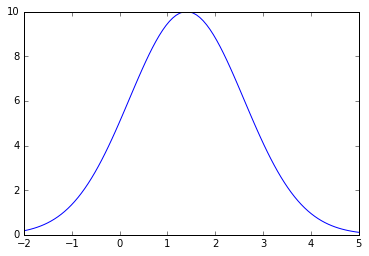

In [27]:
plt.plot(x, data)


Models can be introspected to find out more about the inputs and outputs.

In [34]:
print("gauss.n_inputs:", gauss.n_inputs)
print("gauss.n_outputs:", gauss.n_outputs)

gauss.n_inputs: 1
gauss.n_outputs: 1


### Fitters

Add noise to the data and fit a gaussian.

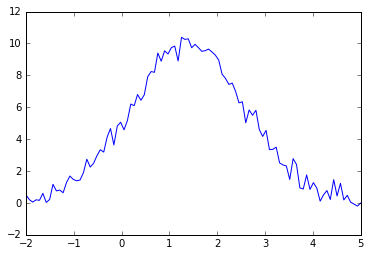

In [35]:
data = gauss(x) + np.random.normal(0, 0.4, x.shape)
plt.plot(x, data)

Fitters are under a common namespace too:

In [36]:
from astropy.modeling import fitting

Create a fitter which uses the Levenberg-Marquardt optimization algorithm and least squares statistics.

Then pass the model and the data to the fitter. The output is a new model with fitted parameters.


In [37]:
fitter = fitting.LevMarLSQFitter()
model = fitter(gauss, x, data)

In [39]:
print(model.parameters)
#print(gauss.parameters)

[ 9.96221675  1.39637714  1.20228252]
[ 10.    1.4   1.2]


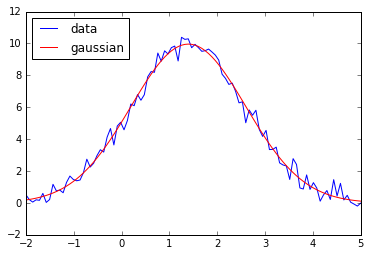

In [40]:
plt.plot(x, data, label='data')
plt.plot(x, model(x), 'r', label='gaussian')
plt.legend(loc=2)

Fitters support parameter constraints of type *fixed*, *tied* and *bounds*.

Fixed parameter constraints are boolean attributes. Let's fix the amplitude to its original value.

In [42]:
gauss.amplitude.fixed = True
model = fitter(gauss, x, data)
print(model.parameters)

[ 10.           1.39637388   1.19918808]


Bounds can be set on a parameter either by using *min* and *max* or the *bounds* attribute.

In [43]:
gauss.stddev.min = .1
gauss.stddev.max = .6
print(gauss.stddev.bounds)

(0.1, 0.6)


To show the mechanism of tieing (or linking) two parameters in the next example the stddev parameter is tied to the amplitude.

In [45]:
def tie_stddev_ampl(model):
    return model.amplitude / 3.78

gauss.stddev.tied = tie_stddev_ampl

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude      mean        stddev   
    --------- ------------- ------------
         10.0 1.29289813441 2.6455026455


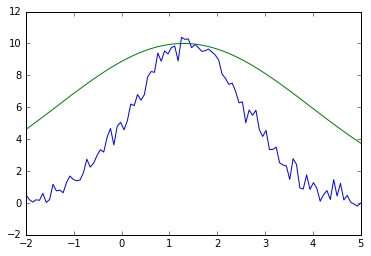

In [46]:
model_tied = fitter(gauss, x, data)
print(model_tied)
plt.plot(x, data)
plt.plot(x, model_tied(x))

Support for parameter constraints varies between fitters. To see what is supported:

In [47]:
print(fitting.LevMarLSQFitter.supported_constraints)

['fixed', 'tied', 'bounds']


astropy.modeling has several other fitters: *SimplexLSQFitter*, *SLSQPLSQFitter* and *LinearLSQFitter*.

The last one can be used only with linear models and provides an exact solution.

#### Example
Create a Chebyshev model, evaluate it and add noise to the data.

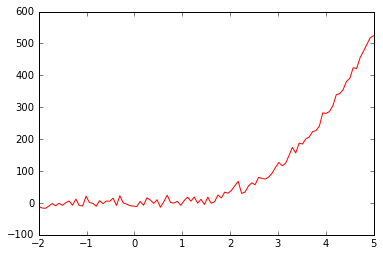

In [48]:
cheb1 = models.Chebyshev1D(degree=3, c0=1, c2=1, c3=1)

data = cheb1(x) + np.random.normal(0, 10, x.shape)
plt.plot(x, data, 'r')

Fit a *Chebyshev1D* polynomial using the *LinearLSQFitter*.

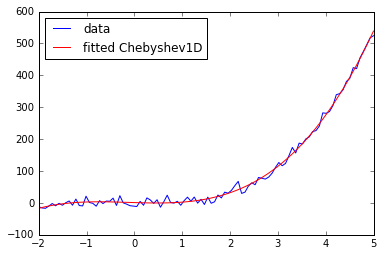

In [49]:
linfitter = fitting.LinearLSQFitter()
model = linfitter(cheb1, x, data)

plt.plot(x, data, label='data')
plt.plot(x, model(x), 'r', label='fitted Chebyshev1D')
plt.legend(loc=2)

### Exercise 1:

#Generate fake data
```
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
```
- Fit the data with a Trapezoid1D model.
- Fit a Gaussian1D model to it.
- Display the results.

### Model Sets

There are cases when it's useful to describe many models of the same type but with different parameter values.
This could be done by passing *n_models* to the model with an integer value indicating the number of models.
This is especially useful in the context of simultaneously fitting many linear models using the *LinearLSQFittter*.

Evaluation of sets of models works for all models while fitting of sets of models is currently supported only for linear models.

In [50]:
poly = models.Polynomial1D(degree=2, c0=0.5, c1=0, c2=1) # one model

poly10 = models.Polynomial1D(degree=2, c0=0.5*np.ones(10), c2=np.ones(10), n_models=10) # 10 models
print(poly10)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 10
Degree: 2
Parameters:
     c0  c1  c2
    --- --- ---
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0
    0.5 0.0 1.0


In [53]:
poly10real = models.Polynomial1D(degree=2, c0=0.5*np.ones(10) * np.random.normal(0, .1, 10),
                             c2=np.ones(10) * np.random.normal(1, .1, 10), n_models=10)
#print(poly10real)

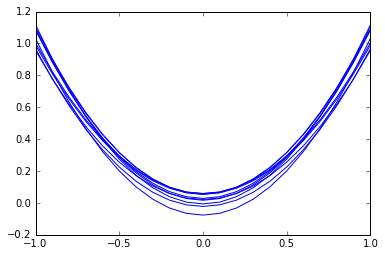

In [61]:
# Evaluate the model on data in the range [-1, 21].

x = np.linspace(-1, 1, 21)
y = poly10real(x, model_set_axis=False)
for i in y:
    plt.plot(x, i, 'b')

In [58]:
fitpoly = linfitter(poly10, x, data)
print(fitpoly)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 10
Degree: 2
Parameters:
            c0                c1              c2      
    ----------------- ----------------- --------------
      0.0167720763301 1.15347846714e-16  1.07219220506
      0.0590524295994               0.0 0.944424848573
      0.0532369349062 1.15347846714e-16  1.04860158383
      0.0580779845399 1.15347846714e-16    1.029971166
     -0.0220528995521 1.15347846714e-16 0.988169137821
    -0.00607028522162               0.0  1.12285967338
     -0.0764065187515 1.15347846714e-16  1.10758801906
      0.0216477192201 1.15347846714e-16  0.93468792652
      0.0549164893339 1.15347846714e-16 0.933103825345
      0.0285062951735 1.15347846714e-16  1.05513270897


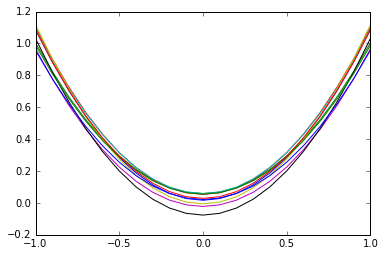

In [64]:
fitdata = fitpoly(x, model_set_axis=False)

for i in fitdata:
    plt.plot(x, i)

### Compound models

astropy.modeling supports model combination using arithmetic operators and the specially defined **join (&)** and **composition ( | )** operators.

In [65]:
g1 = models.Gaussian1D(2, 0, 0.2, name='guass1') # models have names
g2 = models.Gaussian1D(3, 4, 1.5, name='gauss2')
p1 = models.Polynomial1D(1, c0=1, c1=0.2, name='poly')
model = g1 + g2 + p1

Evaluating *model* is equivalent to evluating *g1(x) + g2(x) + p1(x)*.

In [66]:
model(2.5) == g1(2.5) + g2(2.5) + p1(2.5)

True

The other arithmetic operators work similarly. The only requirement is that all models accept the same input.

Compound models support the *param_names* and *parameters* attributes the same way simple models do.

In [67]:
print(model.param_names)
print(model.parameters)

('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1', 'c0_2', 'c1_2')
[ 2.   0.   0.2  3.   4.   1.5  1.   0.2]


Parameter assignment works too. 

In [68]:
model.amplitude_0 = 10
print(model.parameters)

[ 10.    0.    0.2   3.    4.    1.5   1.    0.2]


If child models have names they can be printed, otherwise *None* is printed.

In [69]:
print(model.submodel_names)

('guass1', 'gauss2', 'poly')


Compound models can be sliced or indexed using their names or numerical indices like python lists.

In [71]:
print(model['gauss2'])

Model: Gaussian1D
Name: gauss2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    amplitude mean stddev
    --------- ---- ------
          3.0  4.0    1.5


In [72]:
print(model['gauss2' : ])

Model: CompoundModel2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=3.0, mean=4.0, stddev=1.5, name='gauss2')>

    [1]: <Polynomial1D(1, c0=1.0, c1=0.2, name='poly')>
Parameters:
    amplitude_1 mean_1 stddev_1 c0_2 c1_2
    ----------- ------ -------- ---- ----
            3.0    4.0      1.5  1.0  0.2


The composition operator, *|*, combines models serially by chaining them one after the other. 

The number of outputs of a model must match the number of inputs of the next one.

In [73]:
p2_1 = models.Polynomial2D(degree=1, c0_0=2, c0_1=.1, c1_0=2, name='Poly_X')
rot = models.Rotation2D(angle=23.1, name='Rotation')

Chaining these two models as below is an error because the polynomial has one output, while the rotation has two inputs.

In [74]:
broken_model = p2_1 | rot 

ModelDefinitionError: Unsupported operands for |: Poly_X (n_inputs=2, n_outputs=1) and Rotation (n_inputs=2, n_outputs=2); n_outputs for the left-hand model must match n_inputs for the right-hand model.

The join operator, *&*, evaluates the child models on independent inputs and the results are concatenated.

The number of inputs passed to the combined model must equal the total number of inputs of all models.

In [75]:
p2_2 = models.Polynomial2D(degree=1, c0_0=1, c1_0=2, name='Poly_Y')
model = p2_1 & p2_2 | rot

In [76]:
#x = np.linspace(1, 10, 23)
#y = np.linspace(-10, 10, 23)
#plt.imshow(model(x, y, x, y))
x = 1.2
y = 1.4
print(model(x, y, x, y))

(2.8420434013885805, 4.908603600274077)


The **Mapping** model takes a tuple of indices into the inputs and returns the corresponding inputs. It is useful for changing the order of inputs, dropping or adding inputs. 

In [77]:
model = models.Mapping((0, 1, 0, 1)) | p2_1 & p2_2 | rot
print(model(x, y))

(2.8420434013885805, 4.908603600274077)


Compound models also support parameter constraints. Constraints are defined on parameters of the compound model, not parameters of the submodels.

Example 2:

- read a spectrum from a text file (data/sample.txt).
- Using the rest wavelengths as initial values, fit a gaussian to the H beta and OIII lines.

Use the rest wavelengths as initial values for the locaiton of the lines.
```
Hbeta = 4862.721
Halpha = 6564.614
OIII_1 = 4958.911
OIII_2 = 5008.239
Na = 6549.86
Nb = 6585.27
Sa = 6718.29
Sb = 6732.68
```

### Inverse of a model

Models have their analytical inverse already defined. It is also possible to assign a "custom_inverse" by assigning a model to the *inverse* attribute.

In [78]:
print(rot.inverse)

Model: Rotation2D
Inputs: ('x', 'y')
Outputs: ('x', 'y')
Model set size: 1
Parameters:
    angle
    -----
    -23.1


In [79]:
print(p2_2.inverse)

NotImplementedError: An analytical inverse transform has not been implemented for this model.

In [80]:
p2_2.inverse = p2_1
print(p2_2.inverse)

Model: Polynomial2D
Name: Poly_X
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
    c0_0 c1_0 c0_1
    ---- ---- ----
     2.0  2.0  0.1


### Creating a new model

Quite a few models are already defined in modeling.

In [81]:
models.

SyntaxError: invalid syntax (<ipython-input-81-9e08975948ee>, line 1)

In most cases a new model can be easily defined following an existing model as an example.

However, there's also a decorator, which works with user defined functions and turns them onto models.

In [82]:
from astropy.modeling.models import custom_model

@custom_model
def sine_model(x, amplitude=1, frequency=1):
    return amplitude * np.sin(2 * np.pi * frequency * x)

model = sine_model(amplitude=3, frequency=2.1) # initialize the model
print(model(0.25))

-0.4693033951206922


To supply also a derivative, *custom_model* can be used as a function.

In [83]:
def sine_model(x, amplitude=1, frequency=1):
    return amplitude * np.sin(2 * np.pi * frequency * x)

def sine_deriv(x, amplitude=1, frequency=1):
    return 2 * np.pi * amplitude * np.cos(2 * np.pi * frequency *x)

SineModel = custom_model(sine_model, fit_deriv=sine_deriv) # create the class
model = SineModel(3, 2.1)# and initialize the model
print(model(0.25))

-0.4693033951206922
